In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn import metrics
%matplotlib inline

marathon = pd.read_csv("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")

In [7]:
print('Size of dataset:')
print(marathon.shape,'\n')
print('Data Types:')
print(marathon.dtypes)
print('\n Nulls by Column')
print(marathon.isnull().sum(),'\n')
print('Preview:')
marathon.head()

Size of dataset:
(31984, 21) 

Data Types:
10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

 Nulls by Column
10k              0
name             0
division         0
25k              0
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k              0
overall          0
pace             0
state         2576
30k              0
5k               0
half             0
20k              0
country          0
city             1
40k              0
dtype: int64 

Preview:


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
marathon.dtypes

10k          float64
name          object
division       int64
25k          float64
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k          float64
overall        int64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object

In [3]:
# Remove "-" values and convert remaining to numeric
convert_columns = ['10k','25k','30k','5k','half','20k','40k','35k']

for col in convert_columns:
    marathon = marathon[marathon[col] != '-']
    
marathon[convert_columns] = marathon[convert_columns].apply(pd.to_numeric)

# Get rid of non-numerical columns
numeric = marathon.drop(['name','division','gender','bib','genderdiv','ctz','state','country','city'],axis=1)

# Drop infinity values
numeric = numeric.replace([np.inf, -np.inf], np.nan).dropna(how="any")
numeric = numeric.dropna()

# Normalize results
normalized = pd.DataFrame(normalize(numeric),columns=numeric.columns)

We'll start with k-means clustering. There is no "ground truth" for these clusterings, so we'll be using silhouette coefficients on cross-validation folds to determine which cluster is doing the best job.

In [62]:
from sklearn.model_selection import KFold

# Making 4 equal splits (we'll just be using the "test" one)
kf = KFold(n_splits = 4,shuffle=True,random_state=11)

n_clusters = np.arange(2,11)
silhouette_means = np.array([])
silhouette_stds = np.array([])

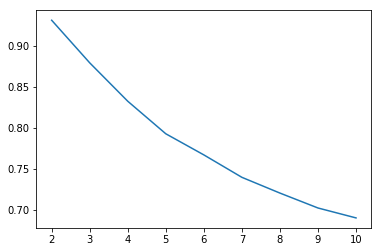

In [36]:
from sklearn.cluster import KMeans
from sklearn import metrics

for num in n_clusters:
    
    silhouette_scores = np.array([])
    
    for train, test in kf.split(normalized):
        model = KMeans(n_clusters=num, random_state=11).fit(normalized.iloc[test,:])
        labels = model.labels_
        score = metrics.silhouette_score(normalized.iloc[test,:], labels, metric='euclidean')

        silhouette_scores = np.append(silhouette_scores,score)
    
    silhouette_mean = silhouette_scores.mean()
    silhouette_std = silhouette_scores.std()
    
    silhouette_means = np.append(silhouette_means,silhouette_mean)
    silhouette_stds = np.array(silhouette_std,silhouette_std)
    
plt.plot(n_clusters,silhouette_means)
plt.show()

Looks like the number of neighbors with the highest silhouette coefficient is simply two. Let's take a look at these two groups and see what we can learn.

In [9]:
# Fitting to entire dataset
model = KMeans(n_clusters=2, random_state=11).fit(normalized)
labels = model.labels_

In [10]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 30946, 1: 703}

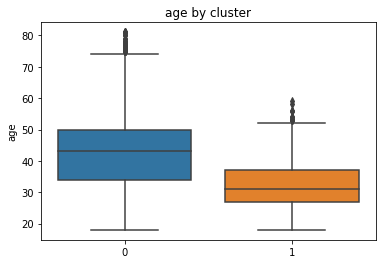

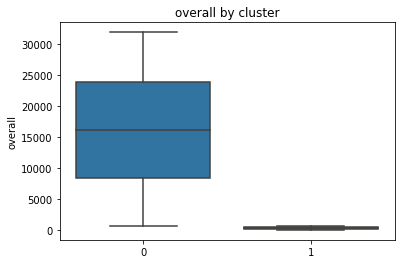

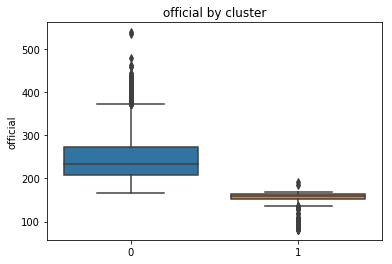

In [11]:
for col in ['age','overall','official']:
    sns.boxplot(labels,marathon[col])
    plt.title("{} by cluster".format(col))
    plt.show()

It looks like the two clusters that K-means clustering has identified are essentially "the pack" and the elite performers. In addition to obviously having substantially lower race times, they have a higher ranking (lower number) and are a younger bunch. Let's see how they compare in terms of gender.

In [16]:
gender_crosstab = pd.crosstab(labels,marathon['gender'])
pct_elite_women = gender_crosstab.iloc[1,0]/gender_crosstab.iloc[:,0].sum()
pct_elite_men = gender_crosstab.iloc[1,1]/gender_crosstab.iloc[:,1].sum()

In [26]:
print("Pct of men in category 1: {0:.3f}%".format(pct_elite_men*100))
print("Pct of women in category 1: {0:.3f}%".format(pct_elite_women*100))

Pct of men in category 1: 3.746%
Pct of women in category 1: 0.339%


A higher percentage of men are in the second cluster vs. that for women. Let's see how countries compare.

In [50]:
country_crosstab = pd.crosstab(labels,marathon['country'])
countries = country_crosstab.columns
elites, pct_elites = (np.array([]) for i in range(2))

def safe_div(x,y):
    if y == 0:
        return None
    return x / y

for country in countries:
    num_elite = country_crosstab[country][1]
    pct_elite = country_crosstab[country][1]/country_crosstab[country].sum()
    
    elites = np.append(elites, num_elite)
    pct_elites = np.append(pct_elites,pct_elite)
    
country_df = pd.DataFrame({'country':countries,'num_elite':elites,'pct_elite':pct_elites})

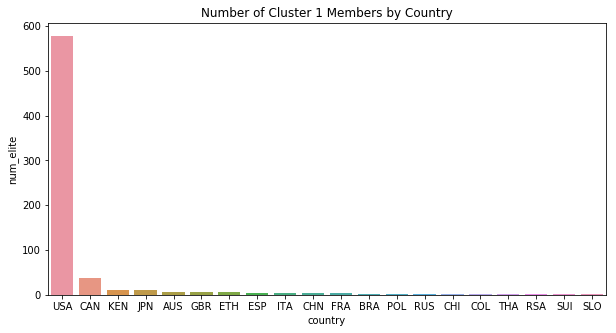

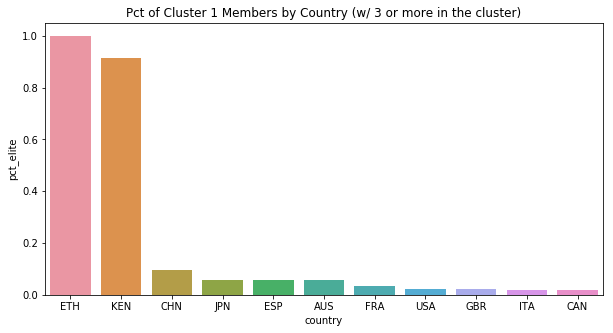

In [60]:
plot_df = country_df.sort_values('num_elite',ascending=False).head(20)

plt.figure(figsize=(10,5))
sns.barplot(plot_df['country'],plot_df['num_elite'])
plt.title("Number of Cluster 1 Members by Country")
plt.show()

plot_df = country_df[country_df['num_elite'] > 2].sort_values('pct_elite',ascending=False).head(20)

plt.figure(figsize=(10,5))
sns.barplot(plot_df['country'],plot_df['pct_elite'])
plt.title("Pct of Cluster 1 Members by Country (w/ 3 or more in the cluster)")
plt.show()

The US and Canada have the most members of cluster 1, but Ethiopia and Kenya have the highest percentage of its runners in Cluster 1. This makes sense since we associate these countries with elite long-distance running.

__Concluding Thoughts on K-Means__
- The highest silhouette score for K-means clustering is generated by 2 clusters, which can generally be thought of as "elite runners" and "the rest"
- The elite cluster has many fewer members than the other cluster, and its members have faster race times, better finishing places, and are generally younger
- A slightly higher percentage of men are in the cluster vs. that for women, and runners from countries like Ethiopia and Kenya have a higher likelihood of being in the cluster

Mean-Shift

In [64]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(normalized, quantile=0.2, n_samples=500)

silhouette_scores = np.array([])

for train, test in kf.split(normalized):
    model = MeanShift(bandwidth=bandwidth).fit(no
                                               rmalized.iloc[test,:])
    labels = model.labels_
    score = metrics.silhouette_score(normalized.iloc[test,:], labels, metric='euclidean')
    print(score)

0.846934238292
0.8537484346
0.861562541529
0.825966025637


In [65]:
# Fitting to the dataset as a whole
model = MeanShift(bandwidth=bandwidth).fit(normalized)
labels = model.labels_

In [72]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 30476,
 1: 664,
 2: 75,
 3: 63,
 4: 56,
 5: 31,
 6: 28,
 7: 23,
 8: 20,
 9: 26,
 10: 29,
 11: 24,
 12: 23,
 13: 20,
 14: 32,
 15: 16,
 16: 20,
 17: 11,
 18: 9,
 19: 2,
 20: 1}

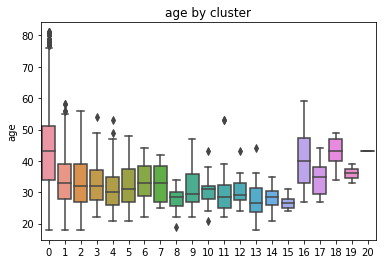

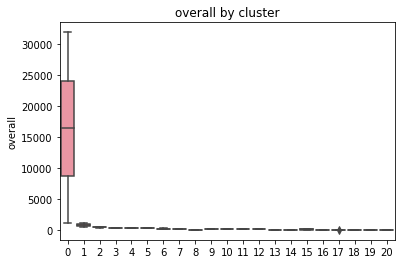

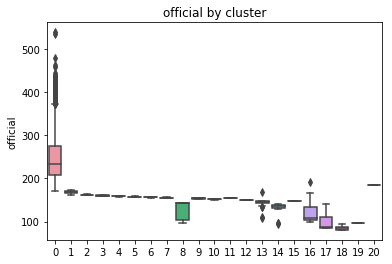

In [67]:
for col in ['age','overall','official']:
    sns.boxplot(labels,marathon[col])
    plt.title("{} by cluster".format(col))
    plt.show()

In [70]:
gender_crosstab = pd.crosstab(labels,marathon['gender'])
gender_crosstab

gender,F,M
row_0,,
0,14097,16379
1,26,638
2,4,71
3,0,63
4,1,55
5,1,30
6,2,26
7,1,22
8,7,13


In [71]:
country_crosstab = pd.crosstab(labels,marathon['country'])
country_crosstab

country,ARG,AUS,AUT,BAH,BAR,BEL,BER,BLR,BOL,BRA,...,TPE,TRI,TUR,UAE,UKR,URU,USA,VEN,VGB,ZIM
row_0,,,,,,,,,,,,,,,,,,,,,
0,14,114,21,2,1,27,17,0,1,84,...,17,1,4,17,2,1,25953,19,1,1
1,0,5,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,576,0,0,0
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,66,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,56,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,46,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,27,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24,0,0,0
7,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,14,0,0,0


Our means-shift model segments the runners by performance in much the same way and produces a strong silhouette coefficient. The groups are perhaps too many to be intelligible for a simple research question, though.

In [4]:
marathon.dtypes

10k          float64
name          object
division       int64
25k          float64
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k          float64
overall        int64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


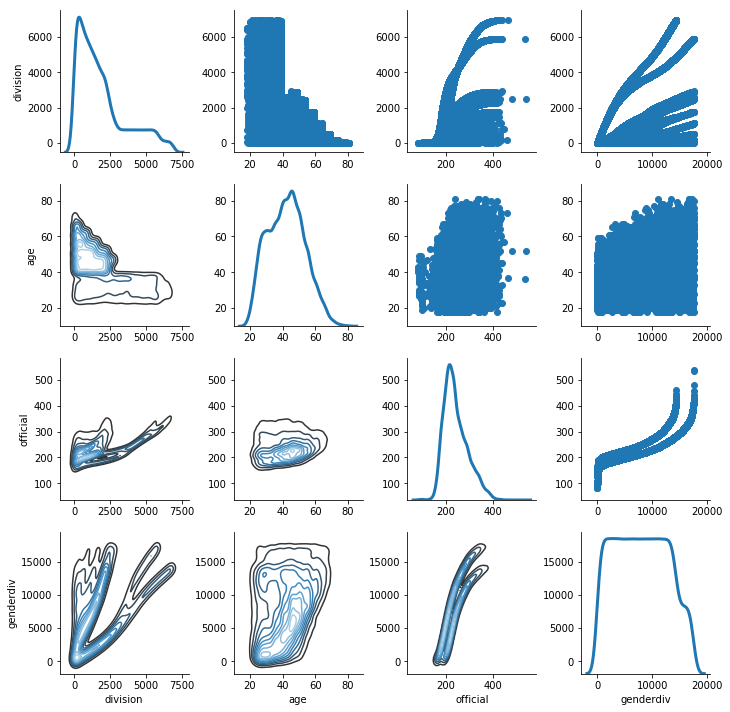

In [5]:
to_plot = marathon[['division','age','gender','official','genderdiv']]

g = sns.PairGrid(to_plot, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

We're seeing some clear separation in some of these groups, so let's try clustering on just these four variables.

In [27]:
numeric = marathon[['division','age','official','genderdiv']]

# Drop infinity values
#numeric = numeric.replace([np.inf, -np.inf], np.nan).dropna(how="any")
#numeric = numeric.dropna()

# Normalize results
#normalized = pd.DataFrame(normalize(numeric),columns=numeric.columns)
normalized = normalize(numeric)

In [29]:
normalize(marathon['age'])

ValueError: Expected 2D array, got 1D array instead:
array=[47. 33. 41. ... 21. 38. 54.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [26]:
normalized[2]

array([0.01105708, 0.45334016, 0.89120042, 0.01105708])

ValueError: x and y must have same first dimension, but have shapes (4,) and (31984,)

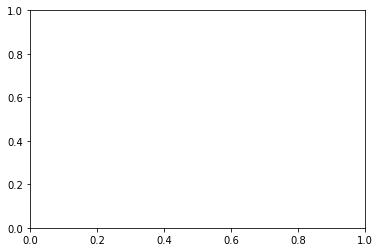

In [25]:
plt.plot(normalized[2],marathon['age'])

In [5]:
from sklearn.model_selection import KFold

# Making 4 equal splits (we'll just be using the "test" one)
kf = KFold(n_splits = 4,shuffle=True,random_state=11)

n_clusters = np.arange(2,11)
silhouette_means = np.array([])
silhouette_stds = np.array([])

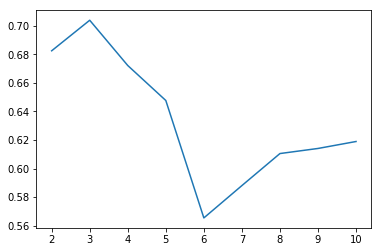

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics

for num in n_clusters:
    
    silhouette_scores = np.array([])
    
    for train, test in kf.split(normalized):
        model = KMeans(n_clusters=num, random_state=11).fit(normalized.iloc[test,:])
        labels = model.labels_
        score = metrics.silhouette_score(normalized.iloc[test,:], labels, metric='euclidean')

        silhouette_scores = np.append(silhouette_scores,score)
    
    silhouette_mean = silhouette_scores.mean()
    silhouette_std = silhouette_scores.std()
    
    silhouette_means = np.append(silhouette_means,silhouette_mean)
    silhouette_stds = np.array(silhouette_std,silhouette_std)
    
plt.plot(n_clusters,silhouette_means)
plt.show()

3 clusters seem to be the most meaningful.

In [6]:
# Fitting to entire dataset
model = KMeans(n_clusters=3, random_state=11).fit(normalized)
labels = model.labels_

In [7]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 20698, 1: 10717, 2: 569}

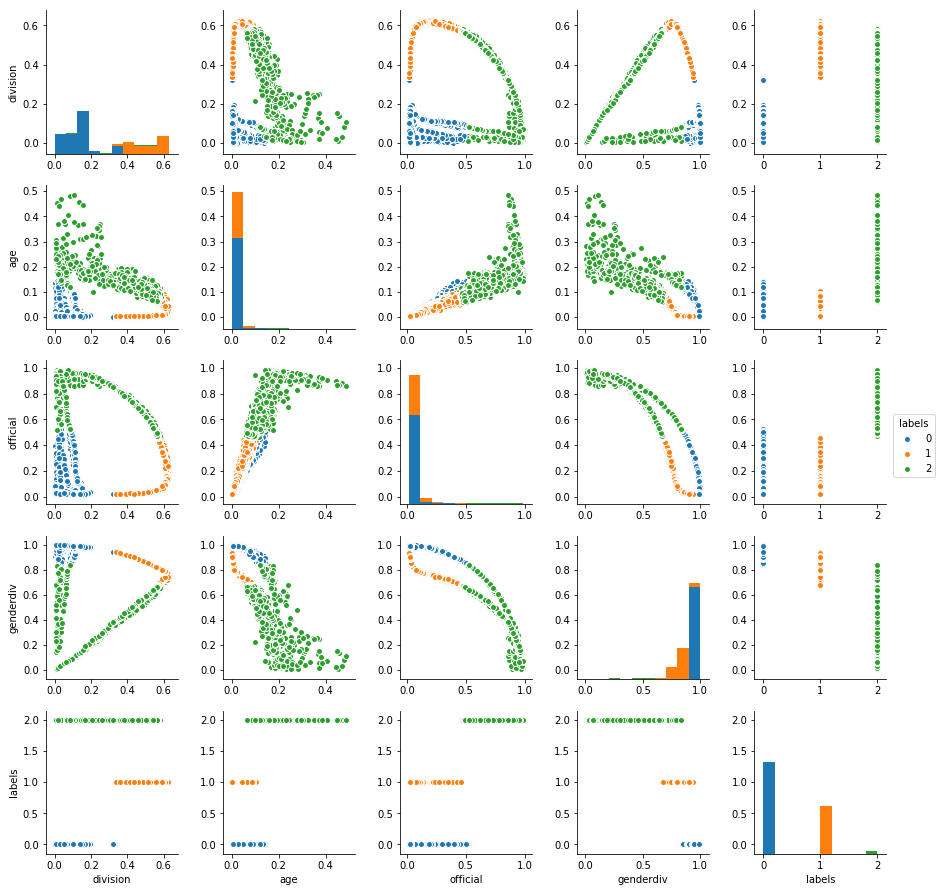

In [10]:
to_plot = normalized[['division','age','official','genderdiv']]
to_plot['labels'] = labels

g = sns.pairplot(to_plot,hue='labels')

In [12]:
to_plot.groupby('labels').mean()

,division,age,official,genderdiv
labels,,,,
0,0.134004,0.007991,0.037344,0.986153
1,0.515051,0.010568,0.067324,0.845661
2,0.324689,0.157369,0.737298,0.454300


In [14]:
marathon['labels'] = labels
marathon.groupby('labels')[['division','age','official','genderdiv']].mean()

,division,age,official,genderdiv
labels,,,,
0,1389.516765,48.487825,251.894971,9427.074886
1,3079.423253,31.196324,230.239226,5814.550621
2,85.586995,32.365554,159.631283,120.351494


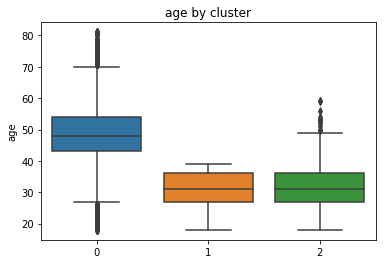

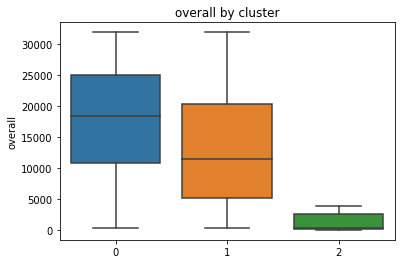

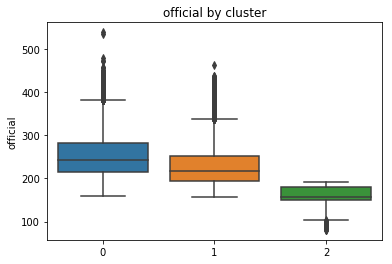

In [11]:
for col in ['age','overall','official']:
    sns.boxplot(labels,marathon[col])
    plt.title("{} by cluster".format(col))
    plt.show()

The clusters make the following general groupings:
- Young runners who are generally quite fast
- Young runners who are more average
- Older runners